In [0]:
import nltk
nltk.download('movie_reviews')
nltk.download('punkt')

import re
import pandas as pd

import matplotlib.pyplot as plt
from nltk.corpus import movie_reviews
from nltk import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import f1_score


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
documents = []
 
for category in movie_reviews.categories():
    for fileid in movie_reviews.fileids(category):
        documents.append((movie_reviews.raw(fileid), category))

df = pd.DataFrame(documents, columns=['review', 'tag'])

df = df.sample(frac=1,random_state=0).reset_index(drop=True).copy()
# separamos entre train y test sets
X = df.review
y = df.tag
X_train_text, X_test_text, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.20, random_state=1234)

# Limpieza del texto
def clean_text(text):
  # En este caso particular no hace falta limpiar los textos
  return text.strip()

def tokenizer(text):
    return [w for w in word_tokenize(text) if w.isalpha()] # si solo nos interesan palabras

# Naive Bayes con GridSearch y PreProcesamiento

In [0]:
# Defino el pipeline
pipeline_NB = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer, stop_words="english")),
                     ('clf', MultinomialNB())])

parameters_NB = {'tfidf__ngram_range': [(1, 2)],
              'tfidf__min_df': [.05, .1],
              'clf__alpha': [0.01,0.1]}

# Fit and tune model
clf_pipe_feature_sel_NB = GridSearchCV(pipeline_NB, parameters_NB,scoring='f1_macro',cv=5,return_train_score=True, n_jobs=-1)
clf_pipe_feature_sel_NB.fit(X_train_text, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [0]:
best_pipeline_feature_sel_NB = clf_pipe_feature_sel_NB.best_estimator_
print("Best Cross-Validation:",clf_pipe_feature_sel_NB.best_score_)
print("\nBest parameters set:")
best_parameters_NB = best_pipeline_feature_sel_NB.get_params()
print("tfidf__ngram_range:",best_parameters_NB["tfidf__ngram_range"])
print("tfidf__min_df:",best_parameters_NB["tfidf__min_df"])
print("clf__alpha:",best_parameters_NB["clf__alpha"])

Best Cross-Validation: 0.7978830651889727

Best parameters set:
tfidf__ngram_range: (1, 2)
tfidf__min_df: 0.05
clf__alpha: 0.01


# Regresión Logística


---




In [0]:
pipeline_log = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer, stop_words="english")),
                     ('clf', LogisticRegression(random_state=0, multi_class='ovr'))])

parameters_log = {'tfidf__ngram_range': [(1, 2), (1, 3)],
              'tfidf__min_df': [.05, .1],
              'clf__penalty': ['l1','l2']}

# Fit and tune model
clf_pipe_feature_sel_log = GridSearchCV(pipeline_log, parameters_log,scoring='f1_macro',cv=5,return_train_score=True, n_jobs=-1)
clf_pipe_feature_sel_log.fit(X_train_text, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [0]:
best_pipeline_feature_sel_log = clf_pipe_feature_sel_log.best_estimator_
print("Best Cross-Validation:",clf_pipe_feature_sel_log.best_score_)
print("\nBest parameters set:")
best_parameters_log = best_pipeline_feature_sel_log.get_params()
print("tfidf__ngram_range:",best_parameters_log["tfidf__ngram_range"])
print("tfidf__min_df:",best_parameters_log["tfidf__min_df"])
print("clf__alpha:",best_parameters_log["clf__penalty"])

Best Cross-Validation: 0.8180493029362605

Best parameters set:
tfidf__ngram_range: (1, 2)
tfidf__min_df: 0.05
clf__alpha: l2


# Performance en el TestSet

In [0]:
print("Naive Bayes tf-idf = ", f1_score(y_test, best_pipeline_feature_sel_NB.predict(X_test_text), average="macro"))
print("Regresión Logística tf-idf = ", f1_score(y_test, best_pipeline_feature_sel_log.predict(X_test_text), average="macro"))


Naive Bayes tf-idf =  0.8023505275864873
Regresión Logística tf-idf =  0.8274126276427441


# Feature Importance


In [0]:
pipeline_FI = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, 
                                               tokenizer=tokenizer, 
                                               stop_words="english", 
                                               ngram_range = best_parameters_log["tfidf__ngram_range"],
                                               min_df      = best_parameters_log["tfidf__min_df"])),
                     ('clf', LogisticRegression(random_state=0, 
                                                multi_class='ovr',
                                                solver = 'lbfgs',
                                                penalty = best_parameters_log["clf__penalty"]))])

m = pipeline_FI.fit(X_train_text, y_train)

features = m[0].vocabulary_
weights  = m[1].coef_[0]


## Palabras importantes para clasificar reviews Postitivos

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25]),
 <a list of 10 Text yticklabel objects>)

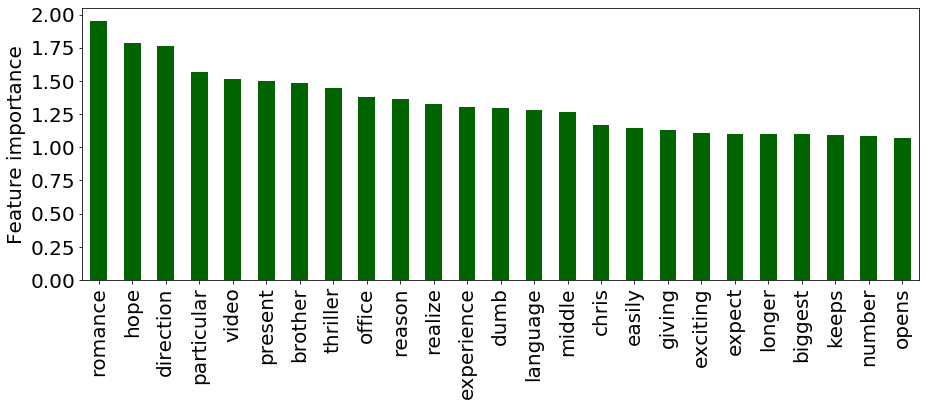

In [0]:
important_Poswords = pd.Series(weights,index=features).sort_values(ascending=False)[:25]
important_Poswords.plot(kind="bar",figsize=(15,5),color="darkgreen")
plt.ylabel("Feature importance",size=20);plt.xticks(size = 20);plt.yticks(size = 20)

## Palabras importantes para clasificar reviews Negativos

(array([-4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ]),
 <a list of 10 Text yticklabel objects>)

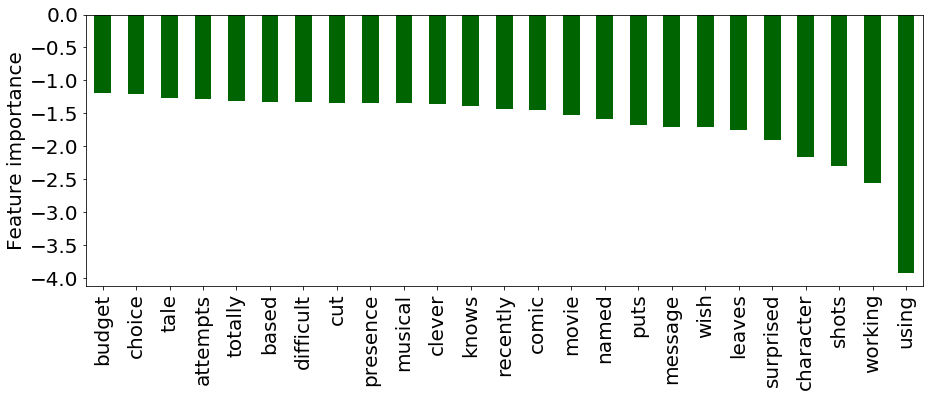

In [0]:
important_Negwords = pd.Series(weights,index=features).sort_values(ascending=False)[-25:]
important_Negwords.plot(kind="bar",figsize=(15,5),color="darkgreen")
plt.ylabel("Feature importance",size=20);plt.xticks(size = 20);plt.yticks(size = 20)

# TF-IDF
### ejemplo

In [0]:
vectorizer = TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer)

In [0]:
train_text = ["mono mono cabra","mono mono elefante","mono mono","mono mono mono mono","mono","mono","elefante"]

In [0]:
tfidf = vectorizer.fit_transform(train_text)

In [0]:
print(vectorizer.get_feature_names())

['cabra', 'elefante', 'mono']


In [0]:
tfidf.toarray()

array([[0.72498682, 0.        , 0.68876274],
       [0.        , 0.65796814, 0.75304577],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ]])

In [0]:
vectorizer.idf_

array([2.38629436, 1.98082925, 1.13353139])

In [0]:
vectorizer.transform(["mono cabra","mono cabra elefante","perro mono"]).toarray()

array([[0.90327141, 0.        , 0.42906965],
       [0.72268898, 0.59989392, 0.34328986],
       [0.        , 0.        , 1.        ]])